# Interpretable Hybrid Model for Visual Pattern Recognition

### Pattern Recognition and Neural Networks (PRNN)

---

## 📌 Project Overview

This project investigates **visual pattern recognition** using both **neural networks** and **classical pattern recognition techniques**, with a strong focus on **model interpretability**.

We begin with a **baseline Convolutional Neural Network (CNN)** trained on the **Fashion-MNIST** dataset to learn hierarchical visual representations. While CNNs achieve strong performance, they often behave as **black-box models**, making it difficult to understand how predictions are made.

To address this limitation, we propose a **hybrid model** that combines:
- **Learned CNN embeddings** (deep features), and  
- **Handcrafted visual descriptors** (HOG and GLCM),

which are fused and classified using a **Random Forest classifier**. This hybrid approach allows us to study how **engineered features and neural representations complement each other** for pattern recognition tasks.

---

## 🎯 Objectives

- Train and evaluate a baseline CNN for image classification  
- Analyze CNN behavior using **Grad-CAM**, **Saliency Maps**, and **Integrated Gradients**  
- Extract and utilize **handcrafted features** for classical pattern recognition  
- Build a **hybrid feature-fusion model** combining CNN and handcrafted features  
- Improve **interpretability** using **feature importance analysis** and **SHAP explanations**  
- Compare performance and interpretability between baseline and hybrid models  

---

## 📊 Dataset

The project uses the **Fashion-MNIST** dataset, a standard benchmark consisting of:
- 28×28 grayscale images  
- 10 clothing categories  
- 60,000 training samples and 10,000 test samples  

Fashion-MNIST provides a controlled environment for analyzing feature representations and interpretability without unnecessary dataset complexity.

---

## 🔍 Key Contributions

- Demonstrates a **hybrid pattern recognition framework**  
- Bridges **classical feature engineering** and **deep learning**  
- Provides **multi-level interpretability** (pixel-level and feature-level)  
- Offers insights into how different feature types influence model decisions  

---

This notebook presents the complete experimental pipeline, results, and interpretability analysis for the proposed hybrid model.


In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Notebook Loaded.")

Notebook Loaded.


## Device Check (MPS/CUDA/CPU)

In [25]:
def get_device():
    if torch.backends.mps.is_available():
        print("✅ Using Apple Metal (mps)")
        return torch.device("mps")
    elif torch.cuda.is_available():
        print("✅ Using CUDA GPU")
        return torch.device("cuda")
    else:
        print("⚠️ Using CPU")
        return torch.device("cpu")

device = get_device()


✅ Using Apple Metal (mps)


## Load Required Modules from your Project

In [26]:
import sys
import os
sys.path.append(os.path.abspath("src"))

from train_utils import ensure_dirs
from handcrafted_features import extract_handcrafted


## Load Baseline CNN Model

In [27]:
import torch.nn as nn
from torchvision import models

def build_resnet18_baseline():
    model = models.resnet18(weights=None)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(512, 10)
    return model

baseline_path = "outputs/models/baseline_cnn.pth"


baseline = build_resnet18_baseline().to(device)
baseline.load_state_dict(torch.load(baseline_path, map_location=device))
baseline.eval()

print("Baseline CNN Loaded.")


Baseline CNN Loaded.


## Evaluate Basline CNN Accuracy

In [28]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

test_data = datasets.FashionMNIST("../data", train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = baseline(x)
        _, pred = torch.max(out, 1)
        correct += (pred == y).sum().item()
        total += len(y)

baseline_acc = correct / total
baseline_acc


0.9276

## Example Image

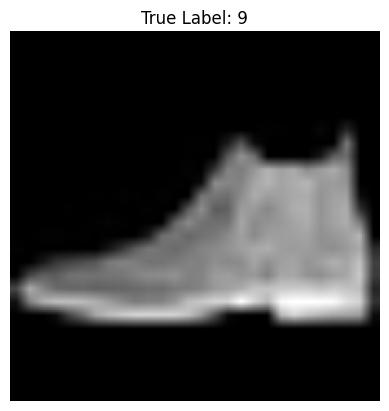

In [29]:
img, label = test_data[0]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(f"True Label: {label}")
plt.axis("off")
plt.show()


## Grad-CAM Visualization

/Users/nishaantmadhan/Desktop/HybridCNNProject/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


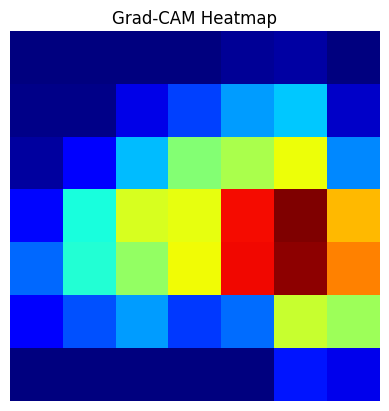

In [30]:
# Grad-CAM hooks
activations = None
gradients = None

def save_activation(module, inp, out):
    global activations
    activations = out.detach()

def save_gradient(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0].detach()

# Attach hooks to last conv block
target_layer = baseline.layer4[-1]
target_layer.register_forward_hook(save_activation)
target_layer.register_backward_hook(save_gradient)

sample = img.unsqueeze(0).to(device)
output = baseline(sample)
pred_class = output.argmax(dim=1).item()

baseline.zero_grad()
output[0, pred_class].backward()

pooled = gradients.mean(dim=[0,2,3])
for i in range(512):
    activations[:, i, :, :] *= pooled[i]

heatmap = activations.mean(dim=1).squeeze().cpu().numpy()
heatmap = np.maximum(heatmap, 0)
heatmap /= heatmap.max()

plt.imshow(heatmap, cmap="jet")
plt.title("Grad-CAM Heatmap")
plt.axis("off")
plt.show()


## Saliency Map

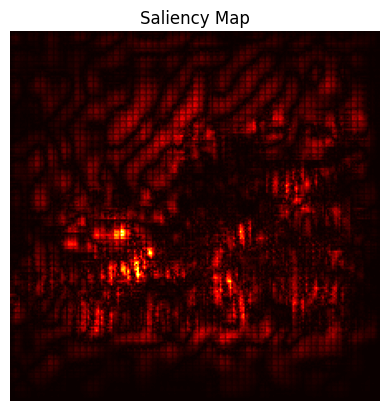

In [31]:
sample = img.unsqueeze(0).to(device)
sample.requires_grad = True

out = baseline(sample)
pred = out.argmax(dim=1)
out[0, pred].backward()

sal = sample.grad.abs().squeeze().cpu().numpy()

plt.imshow(sal, cmap="hot")
plt.title("Saliency Map")
plt.axis("off")
plt.show()


## Integrated Gradients

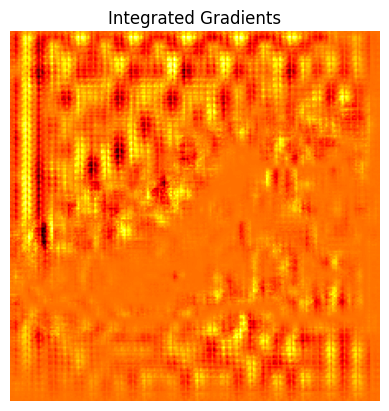

In [32]:
steps = 40
baseline_img = torch.zeros_like(sample)

scaled = [
    baseline_img + (i / steps) * (sample - baseline_img)
    for i in range(steps + 1)
]

grads = []

for s in scaled:
    s = s.to(device)
    s = s.detach().requires_grad_(True)   # ✅ FIX

    out = baseline(s)
    pred = out.argmax(dim=1)

    baseline.zero_grad()
    out[0, pred].backward()

    grads.append(s.grad.detach().cpu().numpy())

avg_grads = np.mean(grads, axis=0)

ig = (sample.detach().cpu().numpy() - baseline_img.cpu().numpy()) * avg_grads

plt.imshow(ig.squeeze(), cmap="hot")
plt.title("Integrated Gradients")
plt.axis("off")
plt.show()


## Load Raw 28x28 Tensors

In [33]:
raw = torch.load("data/fashionmnist_train_tensor.pt")

raw_data = raw["data"]  # list of (img28x28, label)

len(raw_data)


60000

## Build CNN embedder (no FC Layer)

In [34]:
def build_resnet18_embedder():
    model = models.resnet18(weights=None)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Identity()  # remove classifier
    return model

embedder = build_resnet18_embedder().to(device)

state = torch.load("outputs/models/baseline_cnn.pth", map_location=device)

state = {k:v for k,v in state.items() if not k.startswith("fc.")}
embedder.load_state_dict(state, strict=False)
embedder.eval()

print("Embedder Ready.")


Embedder Ready.


## Extract Hybrid Features

In [35]:
X = []
y = []

for img, label in raw_data:
    img4 = img.unsqueeze(0).unsqueeze(0).to(device)

    img224 = torch.nn.functional.interpolate(img4, size=(224,224), mode="bilinear", align_corners=False)
    img224 = (img224 - 0.5) / 0.5

    with torch.no_grad():
        emb = embedder(img224).cpu().numpy().flatten()

    hand = extract_handcrafted(img.numpy())
    X.append(np.concatenate([emb, hand]))
    y.append(label)

X = np.array(X)
y = np.array(y)

X.shape


(60000, 659)

## Train Hybrid RandomForest

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

hybrid_acc = clf.score(X_test, y_test)
hybrid_acc


0.9901666666666666

## Confusion Matrix

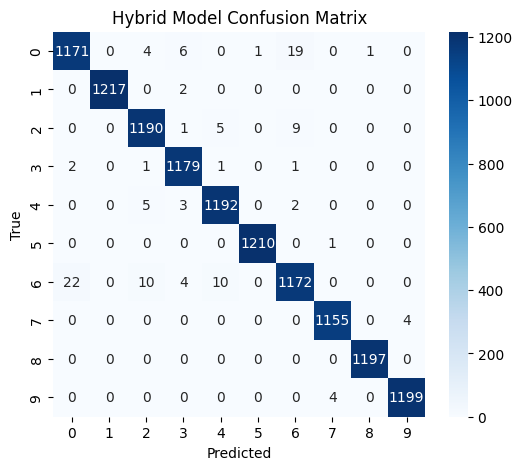

In [37]:
from sklearn.metrics import confusion_matrix

preds = clf.predict(X_test)
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Hybrid Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## SHAP Explainability

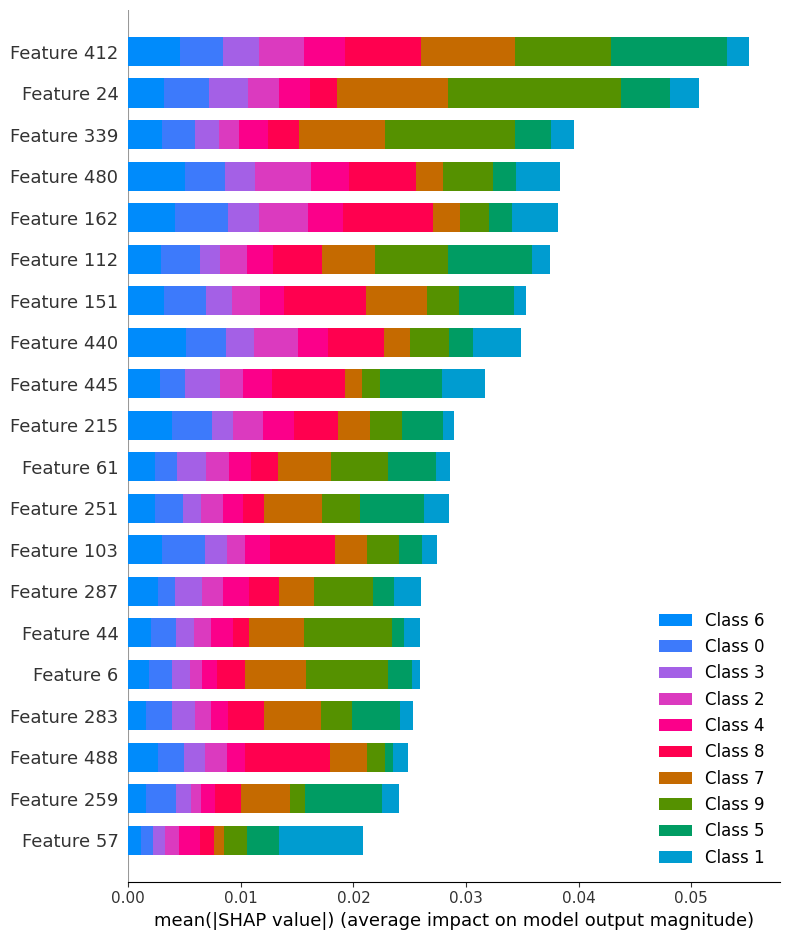

In [38]:
import shap

explainer = shap.TreeExplainer(clf)
X_sample = X_test[:300]

shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample, plot_type="bar")


## SHAP Scatter

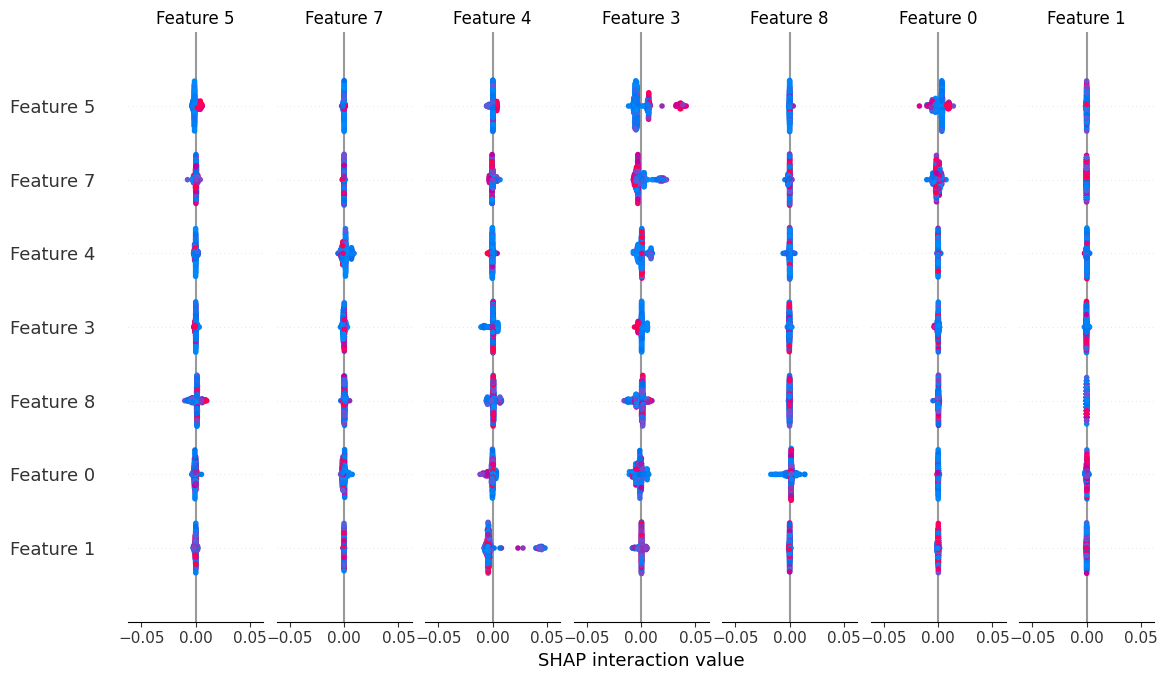

In [39]:
shap.summary_plot(shap_values, X_sample)


## Accuracy Comparison

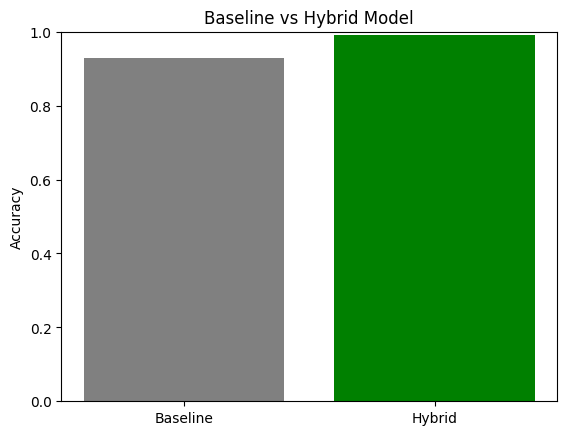

In [40]:
plt.bar(["Baseline", "Hybrid"], [baseline_acc, hybrid_acc], color=["gray", "green"])
plt.ylabel("Accuracy")
plt.title("Baseline vs Hybrid Model")
plt.ylim(0, 1)
plt.show()
